# User Retention Analysis

## Import Packages

In [62]:
!pip install pandas
!pip install numpy
!pip install datetime
!pip install matplotlib
!pip install seaborn


import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## Import Data

In [40]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Online Retail Data.csv')
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
461768,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN
461769,539991,72741,GRAND CHOCOLATECANDLE,4,2010-12-23 16:49:00,1.45,NaN
461770,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1,2010-12-23 17:41:00,3.75,NaN
461771,539992,22258,FELT FARM ANIMAL RABBIT,1,2010-12-23 17:41:00,1.25,NaN


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


## Data Cleansing

In [49]:
df_clean = df.copy()

# mengkonversi kolom order_date menjadi datetime
df_clean['order_date'] = df_clean['order_date'].astype('datetime64[ns]')

# membuat kolom year_month
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')

# menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]

# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]


# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()

# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]

# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')

# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()

# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]

# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)

df_clean

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
360823,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12,delivered,1.25
360824,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
360825,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
360826,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12,delivered,9.90


## Menangani Missing Value

### Data duplicate

In [50]:
print(df_clean.duplicated().sum())

6411


In [51]:
df_drop = df_clean.drop_duplicates()

In [52]:
df_drop.duplicated().sum()

0

### Missing Value

In [53]:
df_drop.isna().sum()

,0
order_id,0
product_code,0
product_name,0
quantity,0
order_date,0
price,0
customer_id,0
year_month,0
order_status,0
amount,0


### Data Outlier

In [54]:
# menghapus outlier
from scipy import stats
df_drop = df_drop[(np.abs(stats.zscore(df_drop[['quantity','amount']]))<3).all(axis=1)]
df_drop = df_drop.reset_index(drop=True)
df_drop

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
352061,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12,delivered,1.25
352062,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
352063,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
352064,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12,delivered,9.90


In [55]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352066 entries, 0 to 352065
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      352066 non-null  object        
 1   product_code  352066 non-null  object        
 2   product_name  352066 non-null  object        
 3   quantity      352066 non-null  int64         
 4   order_date    352066 non-null  datetime64[ns]
 5   price         352066 non-null  float64       
 6   customer_id   352066 non-null  object        
 7   year_month    352066 non-null  period[M]     
 8   order_status  352066 non-null  object        
 9   amount        352066 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 26.9+ MB


## Membuat User Retention Cohort

### Agregasi jumlah transaksi setiap bulan

In [56]:
df_user_monthly = df_drop.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1
...,...,...,...
12039,18286.0,2010-06,1
12040,18286.0,2010-08,1
12041,18287.0,2010-05,1
12042,18287.0,2010-09,2


### Membuat cohort (kelompok) bulan pertama kali bertransaksi

In [57]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
12039,18286.0,2010-06,1,2010-06
12040,18286.0,2010-08,1,2010-06
12041,18287.0,2010-05,1,2010-05
12042,18287.0,2010-09,2,2010-05


### Hitung jarak antara bulan transaksi dengan bulan pertama kali transaksi dan dijumlahkan dengan 1 agar jarak bulan 0 menjadi 1 sebagai bulan pertama

In [58]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
12039,18286.0,2010-06,1,2010-06,1
12040,18286.0,2010-08,1,2010-06,3
12041,18287.0,2010-05,1,2010-05,1
12042,18287.0,2010-09,2,2010-05,5


### Membuat tabel pivot dengan index = cohort, column = jarak bulan (period_num), dan values = pengguna unik (count unique)

In [59]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,713.0,280.0,334.0,313.0,305.0,304.0,293.0,268.0,285.0,319.0,335.0,249.0
2010-02,461.0,154.0,128.0,161.0,152.0,121.0,119.0,159.0,153.0,166.0,100.0,NaN
2010-03,528.0,146.0,158.0,145.0,140.0,123.0,149.0,186.0,193.0,96.0,NaN,NaN
2010-04,326.0,82.0,75.0,63.0,69.0,79.0,98.0,101.0,50.0,NaN,NaN,NaN
2010-05,274.0,55.0,50.0,52.0,52.0,72.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,266.0,53.0,56.0,60.0,65.0,85.0,39.0,NaN,NaN,NaN,NaN,NaN
2010-07,179.0,38.0,37.0,52.0,53.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,48.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,227.0,64.0,60.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Hitung banyaknya pengguna di masing-masing cohort (pengguna yang pertama kali transaksi di bulan tersebut) dan bagi semua nilai di tabel pivot tadi dengan nilai tersebut sebagai retention rate

In [60]:
cohort_size = df_cohort_pivot.iloc[:,0]
cohort_size

,1
cohort,
2010-01,713.0
2010-02,461.0
2010-03,528.0
2010-04,326.0
2010-05,274.0
2010-06,266.0
2010-07,179.0
2010-08,160.0
2010-09,227.0


In [64]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.469846,0.349229
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.344902,0.331887,0.360087,0.216920,NaN
2010-03,1.0,0.276515,0.299242,0.274621,0.265152,0.232955,0.282197,0.352273,0.365530,0.181818,NaN,NaN
2010-04,1.0,0.251534,0.230061,0.193252,0.211656,0.242331,0.300613,0.309816,0.153374,NaN,NaN,NaN
2010-05,1.0,0.200730,0.182482,0.189781,0.189781,0.262774,0.244526,0.156934,NaN,NaN,NaN,NaN
2010-06,1.0,0.199248,0.210526,0.225564,0.244361,0.319549,0.146617,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.212291,0.206704,0.290503,0.296089,0.167598,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.300000,0.168750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.281938,0.264317,0.136564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Menampilkan tabel pivot kedalam brntuk Heatmap

### Tampilan headmap 1 dengan tema merah

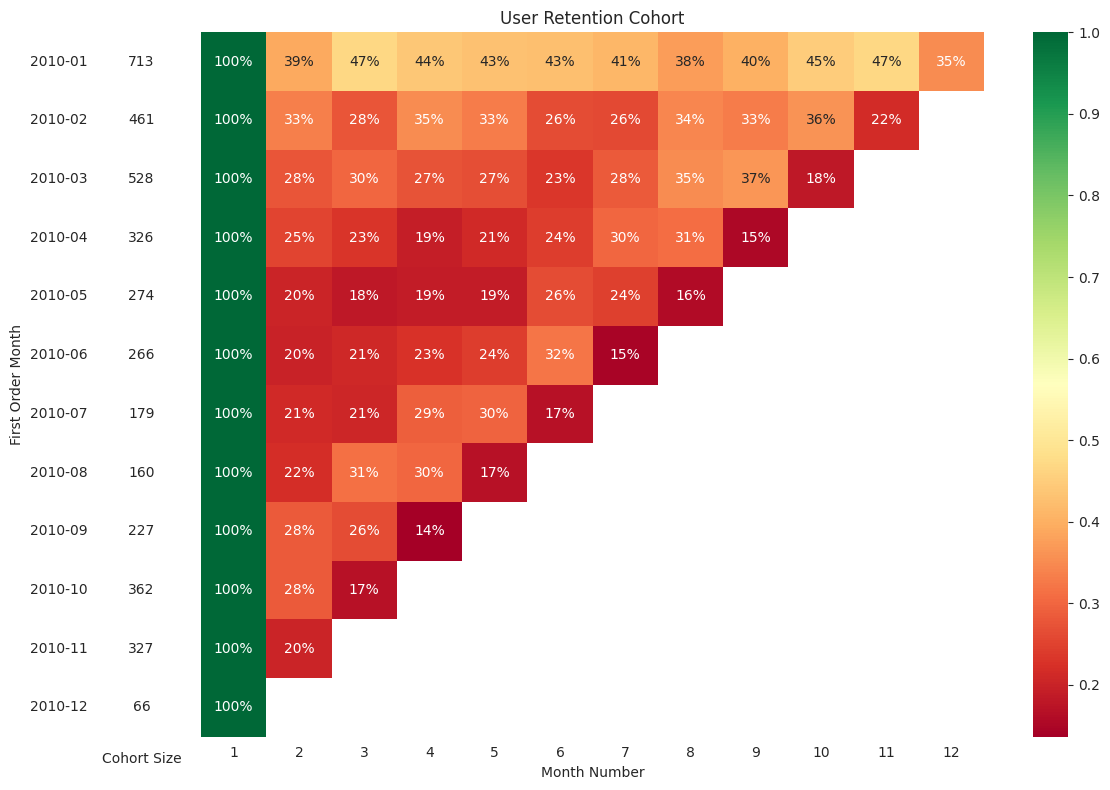

In [65]:
with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()

### Tampilan headmap 2 dengan tema biru

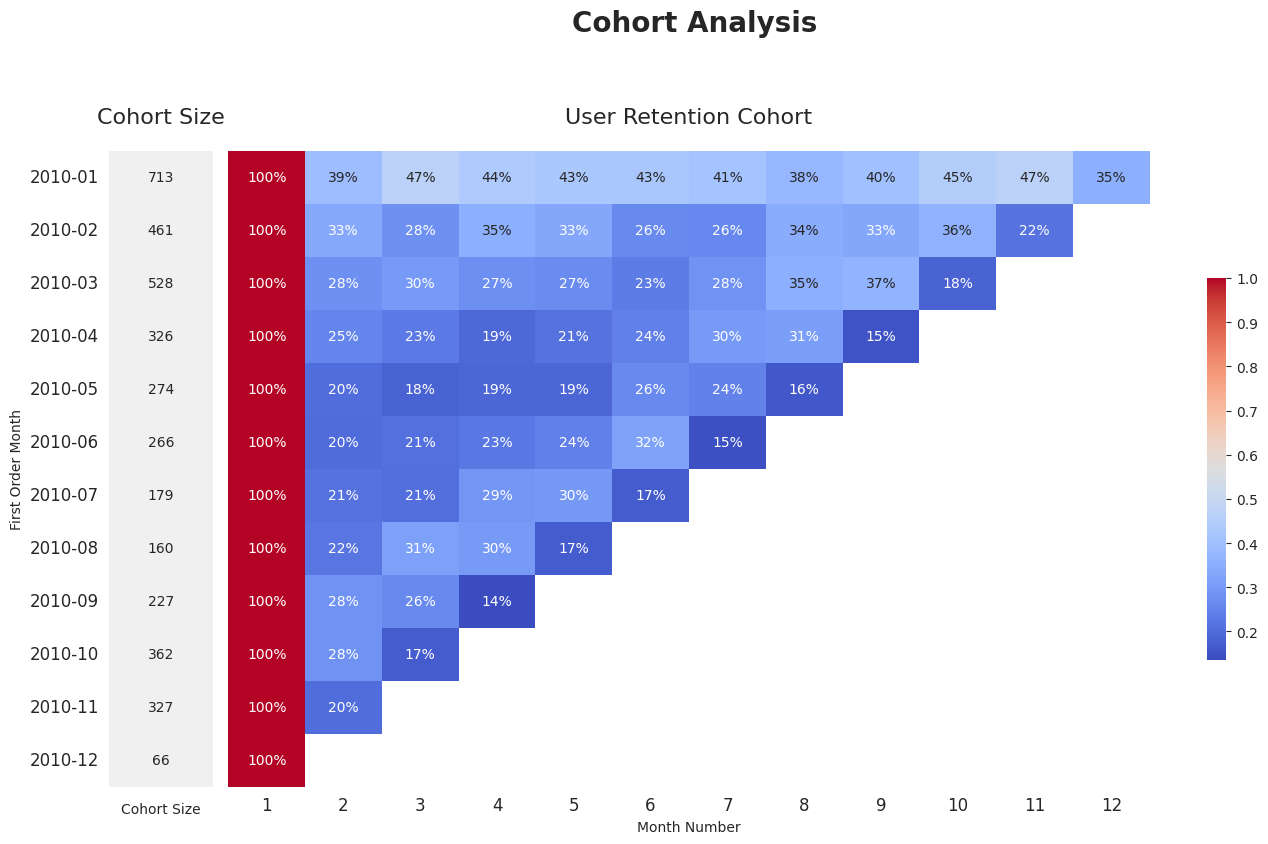

In [68]:
with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # user retention cohort heatmap
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='coolwarm', ax=ax[1],
                cbar_kws={'orientation': 'vertical', 'shrink': 0.6})
    ax[1].set_title('User Retention Cohort', fontsize=16, pad=20)
    ax[1].set(xlabel='Month Number', ylabel='')
    ax[1].tick_params(axis='both', labelsize=12)

    # cohort size heatmap
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['#f0f0f0'])  # Netral soft white background
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False, labelsize=12)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])
    ax[0].set_title('Cohort Size', fontsize=16, pad=20)

    # Adjust spacing between plots
    fig.subplots_adjust(wspace=0.05)
    fig.suptitle('Cohort Analysis', fontsize=20, fontweight='bold', y=1.05)

    fig.tight_layout()

## Analaisis User Retention Cohort



1.   Transaksi **paling banyak yang pertama kali** dilakukan oleh pengguna adalah pada **Januari 2011** yaitu berjumlah **713** pengguna
2.   Cohort pengguna tersebut juga menjadi transaksi yang p**aling  banyak dilakukan kembali di bulan ke-2** yaitu dengan tingkat retensi **sebesar 39%** dibanding cohort yang lain.
3. Cohort tersebut juga menjadi transaksi yang paling loyal untuk bulan-bulan berikutnya dengan retention rate sebesar **kurang lebih 40%**
4. Namun sangat disayangkan, sebagian besar pengguna tidak lagi bertransaksi, yaitu dengan melihat persentase retention rate di banyak cohort yang tidak sampai 50%.
5. Dan kondisi tersebut cukup mengkhawatirkan karena retention rate di bulan Desember 2010 malah menjadi yang terendah dibanding transaksi pada bulan-bulan sebelumnya.




--Terima Kasih--

